In [1]:
import numpy as np
import pandas as pd

def simulate_subject_belief(eta, beta, T=60, q0=0.5, Q_keep=10.0, seed=None):
    rng = np.random.default_rng(seed)
    # trustee cooperation schedule: 1-20 0.8, 21-40 0.5, 41-60 0.8
    coop_probs = np.concatenate([np.full(20, 0.8), np.full(20, 0.5), np.full(20, 0.8)])
    trustee_shared = rng.binomial(1, coop_probs)  # s_t
    q = q0
    q_trace = []
    ev_send_trace = []
    p_send_trace = []
    choices = []
    
    for t in range(T):
        # expected value based on current belief
        ev_send = q * 30.0
        # softmax
        exp_send = np.exp(beta * ev_send)
        exp_keep = np.exp(beta * Q_keep)
        p_send = exp_send / (exp_send + exp_keep)
        choice = rng.binomial(1, p_send)
        
        # record
        q_trace.append(q)
        ev_send_trace.append(ev_send)
        p_send_trace.append(p_send)
        choices.append(choice)
        
        # belief update using observed trustee behavior at this trial
        s_t = trustee_shared[t]
        q = q + eta * (s_t - q)
    
    df = pd.DataFrame({
        "trial": np.arange(1, T+1),
        "trustee_shared": trustee_shared,
        "belief_q": q_trace,
        "EV_send": ev_send_trace,
        "p_send": p_send_trace,
        "choice_send": choices,
        "eta": eta,
        "beta": beta
    })
    return df


In [35]:
import pymc as pm
import numpy as np
import pytensor
import pytensor.tensor as at
from pytensor.scan import scan

# consistent float handling
pytensor.config.floatX = "float64"

def build_belief_model(choices, trustee_shared, q0=0.5, value_scale=10.0):
    """
    choices: binary array (0/1)
    trustee_shared: binary feedback per trial
    value_scale: scaling to keep logits small; default divides (30q - 10) by 10
    """
    choices = np.asarray(choices).astype("int8")
    trustee_shared = np.asarray(trustee_shared, dtype="float64")
    q0 = np.float64(q0)
    value_scale = np.float64(value_scale)

    with pm.Model() as model:
        # more regularized learning rate
        eta = pm.Beta("eta", 2.0, 2.0)  # avoids extremes

        # log-beta with tighter prior
        log_beta = pm.Normal("log_beta", mu=-0.5, sigma=0.7)
        beta = pm.Deterministic("beta", pm.math.exp(log_beta))

        s_seq = at.as_tensor_variable(trustee_shared)          # float64 sequence
        q0_tensor = at.as_tensor_variable(np.array(q0, dtype="float64"))

        def step(s_t, q_prev, eta, beta):
            # scaled difference: (30 q - 10)/value_scale
            scaled_diff = (q_prev * 30.0 - 10.0) / value_scale
            delta = beta * scaled_diff
            p_send_t = pm.math.sigmoid(delta)
            q_new = q_prev + eta * (s_t - q_prev)
            return q_new, p_send_t

        (q_seq, p_send), _ = scan(
            fn=step,
            sequences=s_seq,
            outputs_info=[q0_tensor, None],
            non_sequences=[eta, beta],
        )

        pm.Deterministic("belief_q", q_seq)
        pm.Deterministic("p_send", p_send)

        pm.Bernoulli("obs", p=p_send, observed=choices)

    return model


In [21]:
# create a standard trustee‐sharing schedule
T         = 60
coop_probs= np.concatenate([np.full(20,0.8), np.full(20,0.5), np.full(20,0.8)])
trustee_shared = np.random.default_rng(123).binomial(1, coop_probs, size=T)

# build and sample prior predictive
with build_belief_model(trustee_shared) as prior_model:
    prior_pred = pm.sample_prior_predictive(
        samples=300, 
        var_names=["eta", "beta", "belief_q", "p_send", "y"]
    )


Sampling: [beta, eta, y]


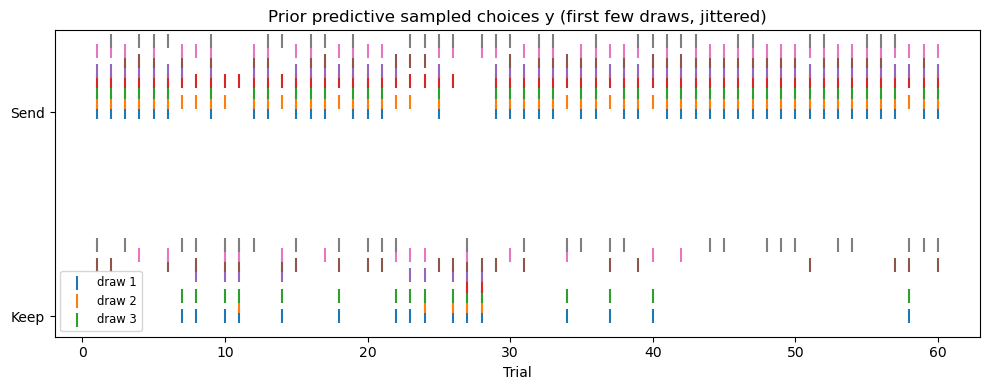

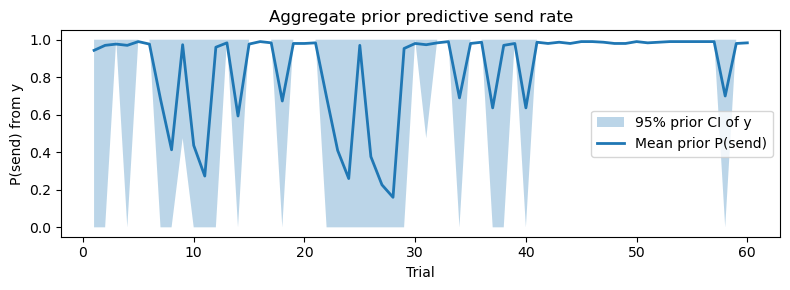

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# --- normalize y_samples to (n_draws, T) ---
ys = y_samples
# if it's an xarray DataArray (from InferenceData), get the raw numpy array
if hasattr(ys, "values"):
    ys = ys.values

# collapse all but last dimension (assume last axis is trial)
# e.g., shape might be (chains, draws, T) or (draws, 1, T) etc.
ys = np.reshape(ys, (-1, ys.shape[-1]))  # now (n_draws, T)
n_draws, T = ys.shape
trials = np.arange(1, T + 1)

# --- raster / few draws of y (jittered) ---
plt.figure(figsize=(10, 4))
n_plot = min(8, n_draws)
for i in range(n_plot):
    plt.scatter(trials, ys[i] + i * 0.05, marker='|', s=100, label=f"draw {i+1}" if i < 3 else None)
plt.yticks([0, 1], ["Keep", "Send"])
plt.ylim(-0.1, 1 + n_plot * 0.05)
plt.xlabel("Trial")
plt.title("Prior predictive sampled choices y (first few draws, jittered)")
plt.legend(fontsize="small")
plt.tight_layout()
plt.show()

# --- aggregate send rate with 95% band ---
mean_y = ys.mean(axis=0)
lower = np.percentile(ys, 2.5, axis=0)
upper = np.percentile(ys, 97.5, axis=0)

plt.figure(figsize=(8, 3))
plt.fill_between(trials, lower, upper, alpha=0.3, label="95% prior CI of y")
plt.plot(trials, mean_y, lw=2, label="Mean prior P(send)")
plt.xlabel("Trial")
plt.ylabel("P(send) from y")
plt.title("Aggregate prior predictive send rate")
plt.legend()
plt.tight_layout()
plt.show()


In [38]:
# simulate one subject
df = simulate_subject_belief(eta=0.3, beta=3.0, seed=123)
choices = df.choice_send.values
trustee_shared = df.trustee_shared.values
print(choices)
print(trustee_shared)

[1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0]


In [36]:
with build_belief_model(choices, trustee_shared) as model:
    trace = pm.sample(
        draws=1000,
        tune=1000,
        target_accept=0.99,   # higher to reduce divergences
        max_treedepth=15,
        return_inferencedata=True
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, log_beta]


c:\Users\kaank\miniconda3\envs\pymc_blas\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [37]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

# 1. Basic posterior summary for key parameters
summary = az.summary(
    trace,
    var_names=["eta", "beta", "log_beta"],
    round_to=2,
    kind="stats"
)
print("Posterior summary:\n", summary)

Posterior summary:
           mean    sd  hdi_3%  hdi_97%
eta       0.33  0.07    0.19     0.45
beta      5.00  2.05    1.99     8.95
log_beta  1.54  0.38    0.88     2.31


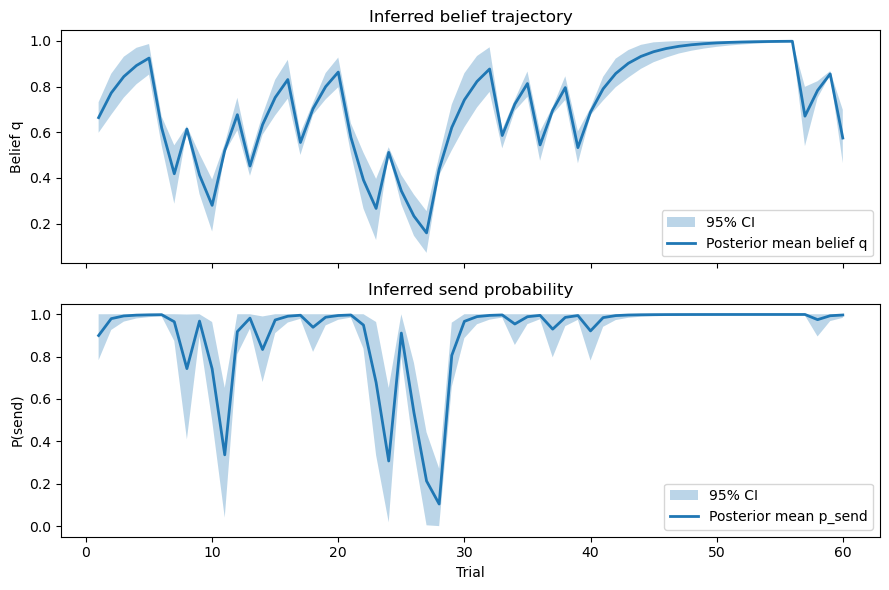

In [40]:
belief_mean = trace.posterior["belief_q"].mean(dim=("chain", "draw")).values.squeeze()
p_send_mean = trace.posterior["p_send"].mean(dim=("chain", "draw")).values.squeeze()
belief_hdi = az.hdi(trace.posterior["belief_q"], hdi_prob=0.95)
p_send_hdi = az.hdi(trace.posterior["p_send"], hdi_prob=0.95)

T = belief_mean.shape[-1]
trials = np.arange(1, T + 1)

fig, axs = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
# belief q
axs[0].fill_between(
    trials,
    belief_hdi["belief_q"].sel(hdi="lower").values,
    belief_hdi["belief_q"].sel(hdi="higher").values,
    alpha=0.3,
    label="95% CI"
)
axs[0].plot(trials, belief_mean, label="Posterior mean belief q", lw=2)
axs[0].set_ylabel("Belief q")
axs[0].set_title("Inferred belief trajectory")
axs[0].legend()

# p_send
axs[1].fill_between(
    trials,
    p_send_hdi["p_send"].sel(hdi="lower").values,
    p_send_hdi["p_send"].sel(hdi="higher").values,
    alpha=0.3,
    label="95% CI"
)
axs[1].plot(trials, p_send_mean, label="Posterior mean p_send", lw=2)
axs[1].set_ylabel("P(send)")
axs[1].set_xlabel("Trial")
axs[1].set_title("Inferred send probability")
axs[1].legend()

plt.tight_layout()
plt.show()

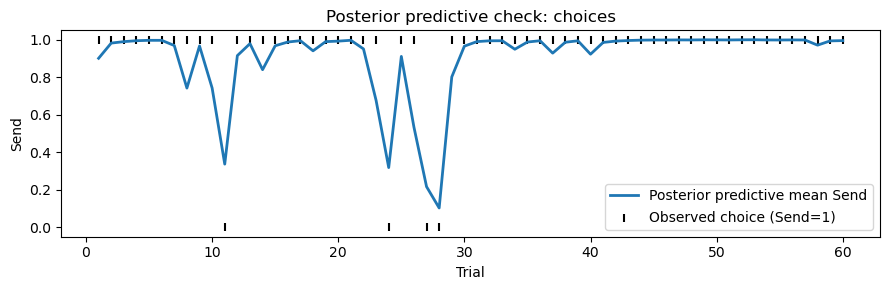

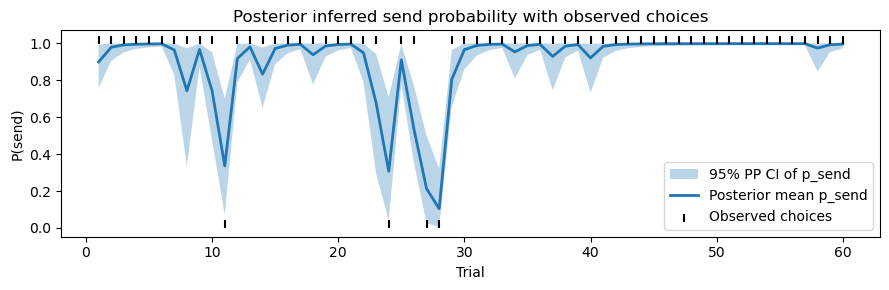

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# extract obs draws robustly
def get_ppc_var(ppc, name):
    # handle dict fallback
    if isinstance(ppc, dict):
        return ppc[name]
    # InferenceData case
    if hasattr(ppc, "posterior_predictive") and name in ppc.posterior_predictive.data_vars:
        arr = ppc.posterior_predictive[name].values
        return arr
    raise KeyError(f"{name} not found in posterior predictive output. Available: {ppc.posterior_predictive.data_vars if hasattr(ppc, 'posterior_predictive') else 'none'}")

ppc_obs = get_ppc_var(ppc, "obs")  # could be shape (chain, draw, T) or (draws, T)
ppc_p_send = get_ppc_var(ppc, "p_send")

# collapse chain/draw axes to (n_samples, T)
def flatten_samples(x):
    if x.ndim == 1:
        return x[None, :]  # unlikely
    return x.reshape(-1, x.shape[-1])

ppc_obs_flat = flatten_samples(ppc_obs)
ppc_p_send_flat = flatten_samples(ppc_p_send)

# posterior predictive mean send choice
mean_ppc_choice = ppc_obs_flat.mean(axis=0)  # length T
mean_p_send = ppc_p_send_flat.mean(axis=0)   # length T
T = mean_ppc_choice.shape[0]
trials = np.arange(1, T+1)

# Plot predictive vs observed (assuming `choices` is your true data)
plt.figure(figsize=(9,3))
plt.plot(trials, mean_ppc_choice, label="Posterior predictive mean Send", lw=2)
plt.scatter(trials, choices, marker="|", color="k", label="Observed choice (Send=1)")
plt.xlabel("Trial")
plt.ylabel("Send")
plt.title("Posterior predictive check: choices") 
plt.legend()
plt.tight_layout()
plt.show()

# Optional: show uncertainty band for p_send
lower = np.percentile(ppc_p_send_flat, 2.5, axis=0)
upper = np.percentile(ppc_p_send_flat, 97.5, axis=0)
plt.figure(figsize=(9,3))
plt.fill_between(trials, lower, upper, alpha=0.3, label="95% PP CI of p_send")
plt.plot(trials, mean_p_send, label="Posterior mean p_send", lw=2)
plt.scatter(trials, choices + 0.02, marker="|", color="k", label="Observed choices", zorder=3)
plt.xlabel("Trial")
plt.ylabel("P(send)")
plt.title("Posterior inferred send probability with observed choices")
plt.legend()
plt.tight_layout()
plt.show()
